In [1]:
import datetime
from platform import python_version
import random
import warnings

# Ensemble Engines
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from DataSetsAuxFun import *
from PredictAssetData import *

from joblib import load
import pickle

class PredictAssetData():
    def __init__(self, 
                 lRawFeatures: list , 
                 lProcessedFeatures: list , 
                 lSelectedFeatures: list,
                 lCatFeatures: list = ['Currency', 'Currency Type', 'Receiver Type']
                       ):
        
        self.predictedLabelsColName = 'Label'
        self.seedNum = 512

        self.lRawFeatures       = lRawFeatures
        self.lProcessedFeatures = lProcessedFeatures
        self.lSelectedFeatures  = lSelectedFeatures
        self.lCatFeatures       = lCatFeatures

    def ValidateData(self, dfData: pd.DataFrame) -> pd.DataFrame:
        
        lDfColName = dfData.columns.to_list()

        for colName in self.lRawFeatures:
            if colName not in lDfColName:
                raise ValueError(f'The column {colName} is missing in the data frame')
        
        # Initialize the Pandas Extension
        numGrps = dfData.GrpBySender.numGrps
        #if numGrps > 1:
        #    raise ValueError(f'The data includes {numGrps} assets instead of 1')

        return dfData

    def CalculateFeatures(self, dfData: pd.DataFrame ) -> pd.DataFrame:
        
        dfData = ApplyListOfFeatures(dfData, self.lProcessedFeatures)

        return dfData
    
    def GenDataPredict(self, dfData: pd.DataFrame ) -> pd.DataFrame:
        
        lNumericalFeatures = [featureName for featureName in self.lSelectedFeatures if featureName not in self.lCatFeatures] 
       
        dfX = dfData[self.lSelectedFeatures].copy()
        dfX.replace([np.inf, -np.inf], np.nan, inplace = True)
        dfX.fillna(0, inplace = True)
        
        hStdScaler = StandardScaler()
        dfX[lNumericalFeatures] = hStdScaler.fit_transform(dfX[lNumericalFeatures])
        
        dfX.rename(columns = {'Amount [USD]': 'Amount USD'}, inplace = True)

        for catColName in self.lCatFeatures:
            if catColName in dfX.columns:
                dfX[catColName] = dfX[catColName].astype('category', copy = False)

        
        dfX['Label'] = dfData['Label']
        dfX['Sender ID'] = dfData['Sender ID']
        
        return dfX

    def TrainModel(self, dfData):
        
        models  = []
        lSelectedFeatures_  = self.lSelectedFeatures ; lSelectedFeatures_[lSelectedFeatures_.index('Amount [USD]')] =  'Amount USD'
        mX = dfData[lSelectedFeatures_]
        vY = dfData['Label']
        
        hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
        for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
            mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
            #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
            xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=self.seedNum, enable_categorical=True)
            xgbModel.fit(mXTrain, vYTrain)
            vYPred = xgbModel.predict(mXTest)
            DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
            print(GenClassifierSummaryResults(vYTest, vYPred))
            models.append(xgbModel)

    def PredictLabels(self, dfX: pd.DataFrame, dfData: pd.DataFrame) -> pd.DataFrame:
       
        
       predictedLabels = self.model.predict(dfX)
       dfData[self.predictedLabelsColName] = predictedLabels  
 
       return dfData   

In [2]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet001'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2
updateInplace       = False

In [3]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42


lRawFeatures = ['Transaction ID', 'Block Time', 'Sender ID', 'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash', 'Currency Type', 'Amount [USD]', 'Label', 'Risk Level']  
lProcessedFeatures =[enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))] #[FeatureName.AMOUNT_MAX_ASSET.name, FeatureName.AMOUNT_MAX_USR.name, FeatureName.TIME_DIFF_MEDIAN_USR.name, FeatureName.TIME_DIFF_MEDIAN_ASSET.name] , 
lCatFeatures = ['Currency', 'Currency Type', 'Receiver Type']
lSelectedFeatures = ['Amount', 'Amount [USD]'] + lProcessedFeatures + lCatFeatures 


timeColStr = 'Block Time'

In [4]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfDataRaw, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
numRows, numCols = dfDataRaw.shape#numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfDataRaw['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfDataRaw.columns} with {len(dfDataRaw.columns)} columns')

The number of file found: 35
The number of rows (Samples): 379887, The number of columns: 19, number of unique sender id's: (35,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level'],
      dtype='object') with 19 columns


In [5]:
# Pre Process Data (Validation)
# We use updateInplace = False in order to not touch the RAW data from the database

dfData = PreProcessData(dfDataRaw, updateInplace = updateInplace, amountUsdOutlierThr = amountUsdOutlierThr)
#dfData['Label'] = -1 #<! Just to verify the model runs


In [6]:
# Instantiate the Class
#oPredAsset.lRawFeatures , oPredAsset.lProcessedFeatures , oPredAsset.lSelectedFeatures, oPredAsset.lCatFeatures
oPredAsset = PredictAssetData(lRawFeatures = lRawFeatures , 
                              lProcessedFeatures = lProcessedFeatures , 
                              lSelectedFeatures = lSelectedFeatures,
                              lCatFeatures = lCatFeatures)

In [7]:
dfData = oPredAsset.ValidateData(dfData)

In [8]:
# Caclucte Features
# We just calculate 4 features for this phase test

dfData = oPredAsset.CalculateFeatures(dfData)

In [9]:
# Gen Data for Prediction
# This creates a different file which is a subset of teh columns in `dfData` and with NaN and `inf` removed
dfX = oPredAsset.GenDataPredict(dfData)

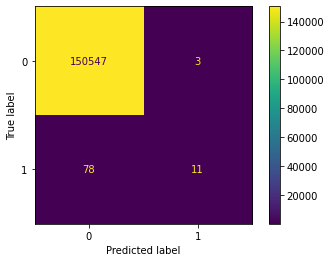

Accuracy         0.999462
F1               0.213592
Precision        0.785714
Recall           0.123596
ROC AUC Score    0.561788
dtype: float64


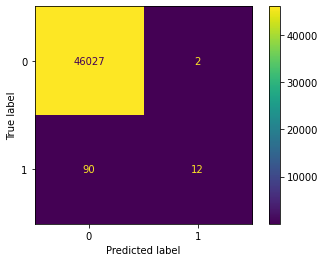

Accuracy         0.998006
F1               0.206897
Precision        0.857143
Recall           0.117647
ROC AUC Score    0.558802
dtype: float64


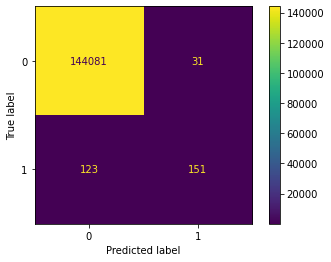

Accuracy         0.998933
F1               0.662281
Precision        0.829670
Recall           0.551095
ROC AUC Score    0.775440
dtype: float64


In [10]:
oPredAsset.TrainModel(dfX)

In [ ]:
# Predict Labels
# Updated the `Label` column in dfData
dfData = oPredAsset.PredictLabels(dfX, dfData)

In [ ]:
dfData['Label']

In [ ]:
a = [1,2,3,4]

In [ ]:
a[a.index(3)] = 5

In [ ]:
a